In [120]:
#Import csv file from DSPM website, label column names and parse date format:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
sales=pd.read_csv("http://liacs.leidenuniv.nl/~takesfw/DSPM/data/sales.csv", names=["saleId", "saleDateTime", "accountName", "coins", "currency", "priceInCurrency", "priceInEUR", "methodId", "ip", "ipCountry"], parse_dates=["saleDateTime"])

In [52]:
#Sort original csv file dates
sales = sales.sort_values(["saleDateTime"])
split1 = sales['saleDateTime'] < '2014-01-01 00:00:00'
sales14 = sales[split1]
split2 = sales['saleDateTime'] > '2013-12-31 23:59:59'
sales15 = sales[split2]

In [53]:
#Define function that returns boolean that shows if frequenty of purchases goes up
def func(x):
    q = True
    if x.iloc[0]['First'] < x.iloc[0]['Last']:
        q = False
    
    return q

In [81]:
#Favorite Countries:
sales["ipCountry"].value_counts().head(5)
fav_countries = ["FR","DE","PL","GP","NL"]
sales["methodId"].value_counts().head(3)
fav_paymethods = [2000,1000,40]

In [54]:
#Create 'customers' DF
customers = pd.DataFrame()
#First feature
customers['countries'] = sales14.groupby("accountName")["ipCountry"].nunique()

In [55]:
#Second feature
customers['lifespan'] = sales14.groupby("accountName")["saleDateTime"].max() - sales14.groupby("accountName")["saleDateTime"].min()
customers['lifespan'] = customers["lifespan"].dt.total_seconds()


In [56]:
#Third feature
customers['lifetime_spend'] = sales14.groupby("accountName")["priceInEUR"].sum()

In [57]:
#Fourth feature
customers['lifetime_trans'] = sales14.groupby("accountName")["saleId"].nunique()

In [109]:
#Fifth feature
tempx = sales14.groupby("accountName")["ipCountry"].value_counts()
temp5 = tempx.groupby("accountName").idxmax()

customers['fav_country'] = pd.Series({item[0]: item[1] for item in temp5}).isin(fav_countries)
customers['fav_country'] = customers['fav_country'].fillna(0)
customers['fav_country'] = customers['fav_country'].astype(int)

In [110]:
#Sixth feature
tempy = sales14.groupby("accountName")["methodId"].value_counts()
temp6 = tempy.groupby("accountName").idxmax()
customers['fav_paymethod'] = pd.Series({item[0]: item[1] for item in temp6}).isin(fav_paymethods)
customers['fav_paymethod'] = customers['fav_paymethod'].fillna(0)
customers['fav_paymethod'] = customers['fav_paymethod'].astype(int)

In [83]:
#Seventh feature
first = sales14.groupby("accountName")["saleDateTime"].nsmallest(2)
last = sales14.groupby("accountName")["saleDateTime"].nlargest(2)
df = pd.DataFrame()
df['First'] = abs(first.diff().reset_index().groupby("accountName").tail(1).set_index("accountName")["saleDateTime"].dt.days)
df['Last'] = abs(last.diff().reset_index().groupby("accountName").tail(1).set_index("accountName")["saleDateTime"].dt.days)
customers["freq_growth"] = df.groupby("accountName").apply(func)
customers["freq_growth"] = customers["freq_growth"].astype(int)

In [84]:
#Eighth feature
trans_growth = {}
for account, group in sales14.groupby('accountName')["priceInEUR"]:
    if group.shape[0] >= 2:
        trans_growth[account] = group.head(2).sum() < group.tail(2).sum()
customers["trans_growth"] = pd.Series(trans_growth)

customers["trans_growth"] = customers["trans_growth"].fillna(0)
customers["trans_growth"] = customers["trans_growth"].astype(int)

In [111]:
#Class feature: Does the customer return, set all to false
loyal = {}
customers["class"] = True
for account, group in customers.groupby('accountName')["class"]:
    if (account in sales15["accountName"].values):
        loyal[account] = True
    else:
        loyal[account] = False
customers["class"] = pd.Series(loyal)
customers["class"] = customers["class"].astype(int)

#customers

,countries,lifespan,lifetime_spend,lifetime_trans,fav_country,fav_paymethod,freq_growth,trans_growth,class
accountName,,,,,,,,,
000113b526fbc8d19f03fccb9,1,5725342.0,14.000,3,1,1,0,0,0
0002c9dd969f5e5831d492524,1,7205755.0,40.000,5,1,0,0,0,0
000697979068d5bbc49dbbd64,1,0.0,10.000,1,0,0,1,0,0
00081bff5faac28727d229ab2,1,0.0,10.000,1,0,1,1,0,0
000b49aef4fdca6601be00775,1,3879836.0,30.000,3,1,1,0,0,1
000ba55fec599714628aa4e3b,1,0.0,20.000,1,1,1,1,0,1
000e9e31fa555ca178e7ab025,2,4342513.0,26.900,15,1,1,0,0,0
000f831d32866742c0c93e1e7,1,0.0,10.000,1,0,1,0,0,0
001879062f1b4dea3719de128,1,0.0,25.000,1,1,0,1,0,0


In [121]:
#Finding the 'best' features, based on insight of a correlation matrix, Chi squared method and inbuilt class feature_importances of tree based classifiers
#First correlation matrix
corr = customers.corr()
#sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
#corr

IndentationError: unexpected indent (<ipython-input-121-6f36b52ed438>, line 5)

In [118]:
#Secondly show best features based on Chi2 selector
data = customers
X = customers.iloc[:,0:8]  #independent features
Y = customers.iloc[:,-1]   #target feature: class
#apply SelectKBest class to extract top 3 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(3,'Score'))  #print 3 best features


            Specs         Score
1        lifespan  4.658707e+10
2  lifetime_spend  1.954931e+05
3  lifetime_trans  4.831898e+04


/home/twumi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.01141445 0.43879584 0.33221823 0.1839038  0.0099534  0.00658993
 0.00470642 0.01241793]


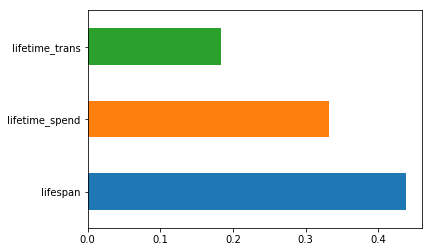

In [119]:
#Show best features based on the scilearn inbuilt feature importance classifier
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(3).plot(kind='barh')
plt.show()

Computing regularization path ...
This took 2.517s


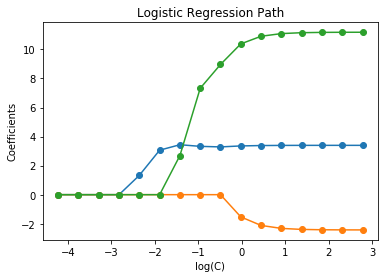

In [142]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

#set data to most important
X = customers.iloc[:,1:4]  #independent features
Y = customers.iloc[:,-1]   #target feature: class

X /= X.max()  # Normalize X to speed-up convergence

#cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

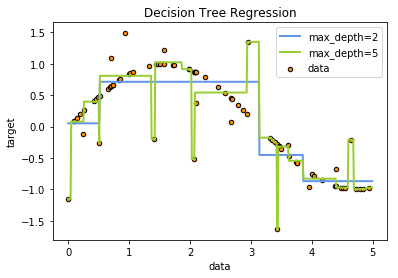

In [149]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()